<a href="https://colab.research.google.com/github/Adam-Aber/Efficient-and-Adversarially-Robust-Electricity-Theft-Detection-Approach/blob/main/Efficient_and_Adversarially_Robust_Electricity_Theft_Detection_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import math
import copy
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
def create_attacks(d):
  alpha1 = random.uniform(0.1,0.2)
  at1 = np.dot(alpha1,d) #1st attack type
  minOffTime=20
  #minOffTime=8
  it = np.random.randint(0, high=47-minOffTime, size=d.shape[0])
  du = np.random.randint(minOffTime, high=48, size=d.shape[0])
  fl = np.minimum(it + du,48)
  at2 = copy.deepcopy(d)
  for l in np.arange(0,d.shape[0]):
    at2[l,it[l]:fl[l]]=0 #2nd attack type
  alpha2 = np.random.uniform(low=0.1, high=0.2, size=(d.shape[0],48))
  at3 = np.multiply(alpha2,d) # 3rd attack type
  avg = np.mean(d,axis=1) # customer daily average consumption
  avg_m = np.diag(avg) # in diagonal matrix for multiplication
  alpha3 = np.random.uniform(low=0.1, high=0.2, size=(d.shape[0],48))
  #alpha3 = np.random.uniform(low=0.1, high=0.5, size=(d.shape[0],48))
  at4 = np.dot(avg_m,alpha3) # 4th attack type
  alpha4 = np.ones((d.shape[0],48))
  at5 = np.dot(avg_m,alpha4) # 5th attack type
  at6 = np.fliplr(d) # 6th attack type
  return at1,at2,at3,at4,at5,at6


In [ ]:
# Load the dataset
D = pd.read_csv('./data.csv', sep=',', header=None)

# Reshape the entire dataset into daily intervals
num_customers = D.shape[0]
all_daily = []
for i in range(num_customers):
    row = D.iloc[i, :].values.reshape(536, 48)  # Reshape each customer's data
    all_daily.append(row)
X_benign = np.vstack(all_daily)

# Generate attack data from the entire benign dataset
num_samples_per_attack = math.ceil(X_benign.shape[0] / 6)
at1, at2, at3, at4, at5, at6 = create_attacks(X_benign[:num_samples_per_attack])

# Concatenate benign and attack data
X_attack = np.concatenate((at1, at2, at3, at4, at5, at6), axis=0)

y_attack = np.ones(X_attack.shape[0])  # Label attack data as 1
y_benign = np.zeros(X_benign.shape[0])  # Label benign data as 0

# Combine benign and attack data into a single dataset
X_combined = np.concatenate((X_benign, X_attack), axis=0)
y_combined = np.concatenate((y_benign, y_attack), axis=0)

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

In [ ]:
np.savetxt('train_features.csv', X_train, delimiter=",")
np.savetxt('train_labels.csv', y_train, delimiter=",")
np.savetxt('test_features.csv', X_test, delimiter=",")
np.savetxt('test_labels.csv', y_test, delimiter=",")

print("Dataset generation complete!")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Dataset generation complete!
X_train shape: (34307, 48), y_train shape: (34307,)
X_test shape: (8577, 48), y_test shape: (8577,)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, MaxPooling1D, Dropout, Input, BatchNormalization

# Load and normalize data
X_train = np.loadtxt('train_features.csv', delimiter=',')
y_train = np.loadtxt('train_labels.csv', delimiter=',')
X_test = np.loadtxt('test_features.csv', delimiter=',')
y_test = np.loadtxt('test_labels.csv', delimiter=',')

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Modified KMeans with enhanced privacy
n_clusters = 7000
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_train)
X_prototypes = kmeans.cluster_centers_

# Prototype label assignment with noise
prototype_counts = [np.bincount(y_train[kmeans.labels_ == i].astype(int)) for i in range(n_clusters)]
y_prototypes = np.array([
    np.random.choice(np.where(counts == counts.max())[0])
    if len(counts) > 0 else np.random.randint(2)
    for counts in prototype_counts
])

In [ ]:
def add_adaptive_noise(X, base_multiplier=0.1):
    noise = np.random.normal(0, base_multiplier, X.shape)
    magnitude = np.abs(X) + 0.2
    nonlinear_factor = np.sin(X * 10) * 0.5
    adaptive_noise = (noise * magnitude) + nonlinear_factor
    return X + adaptive_noise

def create_enhanced_cnn(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        tf.keras.layers.GaussianNoise(0.1),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
        BatchNormalization(),
        Dropout(0.3),
        tf.keras.layers.GaussianNoise(0.1),
        Dense(1, activation='sigmoid')
    ])

    initial_learning_rate = 0.001
    decay_steps = 1000
    decay_rate = 0.9
    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps, decay_rate
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_model_with_privacy(model, X_train, y_train, batch_size=64):
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

    print("Training set class distribution:", np.bincount(y_train_split.astype(int)))
    print("Validation set class distribution:", np.bincount(y_val_split.astype(int)))

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_split, y_train_split))
    train_dataset = train_dataset.shuffle(buffer_size=1000)
    train_dataset = train_dataset.batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices((X_val_split, y_val_split))
    val_dataset = val_dataset.batch(batch_size)

    return model.fit(
        train_dataset,
        epochs=70,
        validation_data=val_dataset,
        verbose=2
    )


In [ ]:
# Apply enhanced privacy measures
X_train_dp = add_adaptive_noise(X_train)
X_test_dp = add_adaptive_noise(X_test)

# Add stronger privacy to prototypes
X_prototypes_dp = add_adaptive_noise(X_prototypes, base_multiplier=0.1)

# Train model on DP prototypes
cnn_prototypes_dp = create_enhanced_cnn((X_prototypes_dp.shape[1], 1))
X_prototypes_dp_expanded = X_prototypes_dp[..., np.newaxis]
history_prototypes = train_model_with_privacy(cnn_prototypes_dp, X_prototypes_dp_expanded, y_prototypes)

Training set class distribution: [4593 1007]
Validation set class distribution: [1120  280]
Epoch 1/70
88/88 - 20s - 228ms/step - accuracy: 0.8955 - loss: 24.2520 - val_accuracy: 0.8000 - val_loss: 5.4318
Epoch 2/70
88/88 - 7s - 80ms/step - accuracy: 0.9675 - loss: 3.3697 - val_accuracy: 0.8000 - val_loss: 2.4913
Epoch 3/70
88/88 - 1s - 7ms/step - accuracy: 0.9666 - loss: 2.1243 - val_accuracy: 0.8000 - val_loss: 2.4662
Epoch 4/70
88/88 - 0s - 3ms/step - accuracy: 0.9645 - loss: 1.9693 - val_accuracy: 0.8000 - val_loss: 2.3134
Epoch 5/70
88/88 - 0s - 3ms/step - accuracy: 0.9688 - loss: 1.7814 - val_accuracy: 0.8000 - val_loss: 2.0194
Epoch 6/70
88/88 - 0s - 3ms/step - accuracy: 0.9688 - loss: 1.6970 - val_accuracy: 0.8007 - val_loss: 1.6147
Epoch 7/70
88/88 - 0s - 3ms/step - accuracy: 0.9693 - loss: 1.4649 - val_accuracy: 0.9621 - val_loss: 1.6751
Epoch 8/70
88/88 - 0s - 4ms/step - accuracy: 0.9689 - loss: 1.3340 - val_accuracy: 0.8729 - val_loss: 1.2234
Epoch 9/70
88/88 - 1s - 7ms/ste

In [ ]:
# Train model on raw data with DP
cnn_original_dp = create_enhanced_cnn((X_train.shape[1], 1))
X_train_original_dp = X_train_dp[..., np.newaxis]
X_test_original_dp = X_test_dp[..., np.newaxis]
history_original = train_model_with_privacy(cnn_original_dp, X_train_original_dp, y_train)

Training set class distribution: [13689 13756]
Validation set class distribution: [3449 3413]
Epoch 1/70
429/429 - 19s - 45ms/step - accuracy: 0.9408 - loss: 6.7067 - val_accuracy: 0.8955 - val_loss: 1.8500
Epoch 2/70
429/429 - 1s - 3ms/step - accuracy: 0.9504 - loss: 1.3972 - val_accuracy: 0.9736 - val_loss: 1.2696
Epoch 3/70
429/429 - 2s - 6ms/step - accuracy: 0.9534 - loss: 1.0908 - val_accuracy: 0.9623 - val_loss: 1.0436
Epoch 4/70
429/429 - 1s - 3ms/step - accuracy: 0.9527 - loss: 0.9561 - val_accuracy: 0.9760 - val_loss: 0.8684
Epoch 5/70
429/429 - 1s - 3ms/step - accuracy: 0.9539 - loss: 0.8316 - val_accuracy: 0.9678 - val_loss: 0.8314
Epoch 6/70
429/429 - 1s - 3ms/step - accuracy: 0.9563 - loss: 0.7568 - val_accuracy: 0.9682 - val_loss: 0.6493
Epoch 7/70
429/429 - 3s - 6ms/step - accuracy: 0.9578 - loss: 0.7085 - val_accuracy: 0.9840 - val_loss: 0.6340
Epoch 8/70
429/429 - 3s - 6ms/step - accuracy: 0.9572 - loss: 0.6464 - val_accuracy: 0.9799 - val_loss: 0.5719
Epoch 9/70
429/4

In [ ]:
import numpy as np
import tensorflow as tf

data_range = np.max(X_train_dp) - np.min(X_train_dp)
prototype_range = np.max(X_prototypes_dp) - np.min(X_prototypes_dp)

def gradient_inversion_attack_limited(model, x_true, y_true, data_range, steps=500):

    # Initialize reconstruction with random noise
    x_reconstructed = np.random.normal(size=x_true.shape)
    x_reconstructed = tf.Variable(x_reconstructed, dtype=tf.float32)

    regularization_strength = 0.5
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    # Track L2 distance each iteration
    l2_history = []
    # Convert x_true to a tf.Tensor for distance calculations
    x_true_tensor = tf.constant(x_true, dtype=tf.float32)

    for step in range(steps):
        with tf.GradientTape() as tape:
            # Forward pass
            predictions = model(x_reconstructed, training=False)
            reconstruction_loss = tf.keras.losses.MSE(y_true, predictions)

            # Add regularization terms
            l2_loss = regularization_strength * tf.reduce_sum(tf.square(x_reconstructed))
            l1_loss = regularization_strength * 0.5 * tf.reduce_sum(tf.abs(x_reconstructed))
            smoothness_loss = (
                regularization_strength * 0.3 *
                tf.reduce_sum(tf.square(x_reconstructed[..., 1:] - x_reconstructed[..., :-1]))
            )
            total_loss = reconstruction_loss + l2_loss + l1_loss + smoothness_loss

        # Compute gradients
        grads = tape.gradient(total_loss, [x_reconstructed])

        # Noisy channel for transmitting gradients
        x_reconstructed.assign_add(tf.random.normal(x_reconstructed.shape, mean=0, stddev=0.02 * data_range))
        x_reconstructed.assign(tf.clip_by_value(x_reconstructed, -data_range, data_range))

        # Track the L2 distance between x_reconstructed and x_true
        diff = x_reconstructed - x_true_tensor
        l2_distance = tf.norm(diff, ord=2)
        l2_history.append(l2_distance.numpy())

    return x_reconstructed.numpy(), l2_history

In [ ]:
# -------------------------
# 5. GI Attack on a sample
# -------------------------

# Choose sample from testing dataset to reconstruct
sample_idx = 1
X_test_sample = X_test[sample_idx:sample_idx+1]
y_test_sample = y_test[sample_idx:sample_idx+1]

reconstructed_array, l2_history = gradient_inversion_attack_limited(
    model=cnn_original_dp,
    x_true=X_test_sample,
    y_true=y_test_sample,
    data_range=data_range,
    steps=500
)

reconstructed_prototypes_dp, l2_history_prototypes = gradient_inversion_attack_limited(
    model=cnn_prototypes_dp,
    x_true=X_test_sample,
    y_true=y_test_sample,
    data_range=prototype_range,
    steps=500
)

print("Reconstruction complete!")


Reconstruction complete!


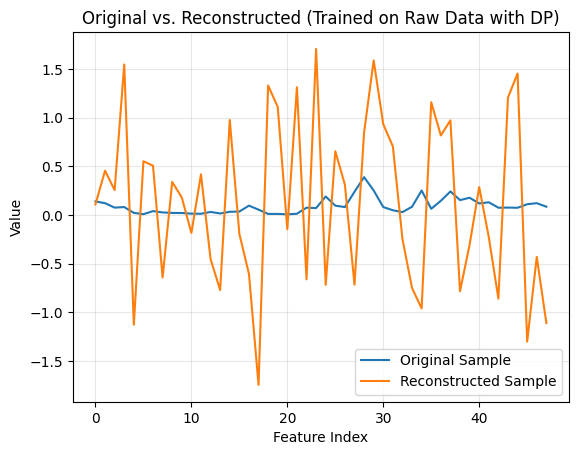

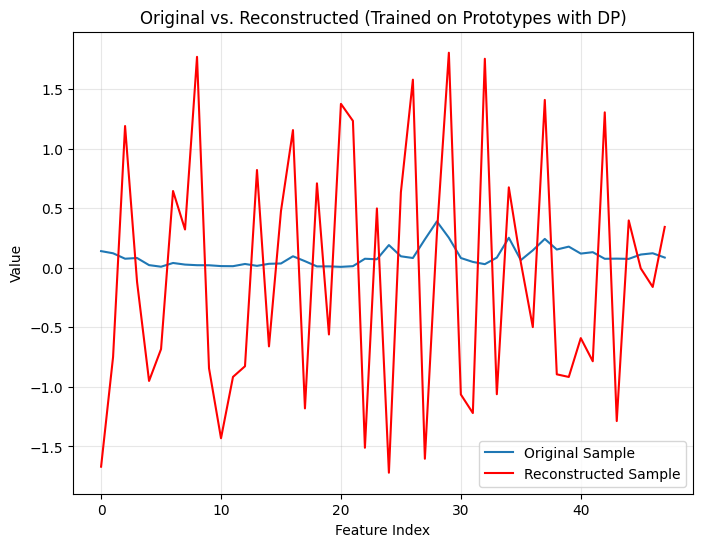

Evaluating models on test set...
X_test_dp shape: (8577, 48)
X_test_original_dp shape: (8577, 48, 1)
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

CNN Model Trained on Raw Data with DP:
Accuracy:  0.9745
Precision: 0.9535
Recall:    0.9974
F1 Score:  0.9750
FA Rate:   0.0483
AUC:       0.9979

CNN Model Trained on Prototypes with DP:
Accuracy:  0.9190
Precision: 0.9771
Recall:    0.8575
F1 Score:  0.9134
FA Rate:   0.0200
AUC:       0.9866


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    mean_squared_error,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    confusion_matrix
)

# -------------------------
# 6. Visualize Training History
# -------------------------
# plt.figure(figsize=(12, 5))
# plt.plot(history_original.history['accuracy'], label='Training Accuracy')
# plt.plot(history_original.history['val_accuracy'], label='Validation Accuracy')
# plt.title('CNN Training History (Raw Data)')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# -------------------------
# 7. Visualize Reconstruction
# -------------------------
plt.plot(X_test_sample.flatten(), label='Original Sample')
plt.plot(reconstructed_array.flatten(), label='Reconstructed Sample')
plt.title('Original vs. Reconstructed (Trained on Raw Data with DP)')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(X_test_sample.flatten(), label='Original Sample')
plt.plot(reconstructed_prototypes_dp.flatten(), label='Reconstructed Sample', color='red')
plt.title('Original vs. Reconstructed (Trained on Prototypes with DP)')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# -------------------------
# 8. Evaluate Model on Test Set + Extended Metrics
# -------------------------
print("Evaluating models on test set...")

# 8.1. Get model predictions (probabilities) and convert to class labels

X_test_original_dp = X_test_dp[..., np.newaxis]
print("X_test_dp shape:", X_test_dp.shape)
print("X_test_original_dp shape:", X_test_original_dp.shape)

y_pred_probs = cnn_original_dp.predict(X_test_dp).flatten()
y_pred_labels = (y_pred_probs >= 0.5).astype(int)

y_pred_probs_prototype = cnn_prototypes_dp.predict(X_test_dp).flatten()
y_pred_labels_prototype = (y_pred_probs_prototype >= 0.5).astype(int)

# 8.2. Compute basic metrics
### CNN Model Trained on Raw Data with DP

acc = accuracy_score(y_test, y_pred_labels)
precision = precision_score(y_test, y_pred_labels)
recall = recall_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels)

# Compute ROC-related metrics
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
auc_score = roc_auc_score(y_test, y_pred_probs)

# Compute False Alarm (FA) Rate
# For binary classification: FA Rate = FP / (FP + TN) = 1 - specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_labels).ravel()
fa_rate = fp / (fp + tn)

### CNN Model Trained on Prototypes with DP
acc_prototype = accuracy_score(y_test, y_pred_labels_prototype)
precision_prototype = precision_score(y_test, y_pred_labels_prototype)
recall_prototype = recall_score(y_test, y_pred_labels_prototype)
f1_prototype = f1_score(y_test, y_pred_labels_prototype)

fpr_prototype, tpr_prototype, thresholds_prototype = roc_curve(y_test, y_pred_probs_prototype)
auc_score_prototype = roc_auc_score(y_test, y_pred_probs_prototype)

tn_prototype, fp_prototype, fn_prototype, tp_prototype = confusion_matrix(y_test, y_pred_labels_prototype).ravel()
fa_rate_prototype = fp_prototype / (fp_prototype + tn_prototype)

# Print the metrics
print("\nCNN Model Trained on Raw Data with DP:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"FA Rate:   {fa_rate:.4f}")
print(f"AUC:       {auc_score:.4f}")

print("\nCNN Model Trained on Prototypes with DP:")
print(f"Accuracy:  {acc_prototype:.4f}")
print(f"Precision: {precision_prototype:.4f}")
print(f"Recall:    {recall_prototype:.4f}")
print(f"F1 Score:  {f1_prototype:.4f}")
print(f"FA Rate:   {fa_rate_prototype:.4f}")
print(f"AUC:       {auc_score_prototype:.4f}")

# # 8.5. Plot the ROC Curve
# plt.figure(figsize=(7, 5))
# plt.plot(fpr, tpr, label=f"ROC curve Raw (AUC = {auc_score:.4f})", color='blue')
# plt.plot(fpr_prototype, tpr_prototype, label=f"ROC curve Prototype (AUC = {auc_score_prototype:.4f})", color='orange')
# plt.plot([0, 1], [0, 1], 'r--')  # diagonal line
# plt.title("Receiver Operating Characteristic (ROC)")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.legend(loc="lower right")
# plt.grid(True, alpha=0.3)
# plt.show()



Reconstruction Metrics for Model on Raw Data with DP:
   MSE:   0.7703

Reconstruction Metrics for Model on Prototypes with DP:
   MSE:   1.1245


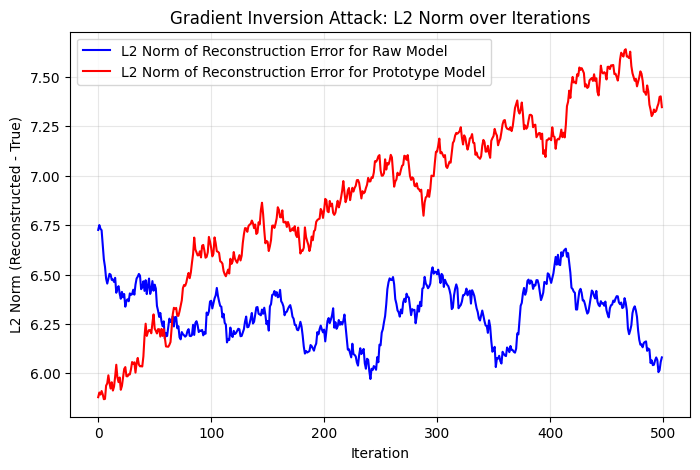

In [ ]:
# -------------------------
# 9. Calculate Reconstruction Metrics
# -------------------------

mse_reconstruction = mean_squared_error(X_test_sample.flatten(), reconstructed_array.flatten())
mse_reconstruction_prototype = mean_squared_error(X_test_sample.flatten(), reconstructed_prototypes_dp.flatten())

print("\nReconstruction Metrics for Model on Raw Data with DP:")
print(f"   MSE:   {mse_reconstruction:.4f}")

print("\nReconstruction Metrics for Model on Prototypes with DP:")
print(f"   MSE:   {mse_reconstruction_prototype:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(l2_history, label='L2 Norm of Reconstruction Error for Raw Model', color='blue')
plt.plot(l2_history_prototypes, label='L2 Norm of Reconstruction Error for Prototype Model', color='red')
plt.title('Gradient Inversion Attack: L2 Norm over Iterations')
plt.xlabel('Iteration')
plt.ylabel('L2 Norm (Reconstructed - True)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()